In [1]:
import sys
import json

import torch

import torch.nn.functional as F

In [2]:
SRC_PATH = './src'
if SRC_PATH not in sys.path:
    sys.path.insert(-1, SRC_PATH)
    print(sys.path)
    
from models import CifarResNet50
from resnet import ResNet50
from utils import *
from data_factory import *
from main import *


['/home/xuanyu/tmp/tmp_dir/GAN', '/home/xuanyu/anaconda3/envs/debatestar/lib/python37.zip', '/home/xuanyu/anaconda3/envs/debatestar/lib/python3.7', '/home/xuanyu/anaconda3/envs/debatestar/lib/python3.7/lib-dynload', '', '/home/xuanyu/anaconda3/envs/debatestar/lib/python3.7/site-packages', '/home/xuanyu/anaconda3/envs/debatestar/lib/python3.7/site-packages/IPython/extensions', './src', '/home/xuanyu/.ipython']


In [108]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def pgd(model, X, y, epsilon, alpha=10/255, num_iter=20):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
#         loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss = F.nll_loss(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return X + delta.detach()



def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
#     loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss = F.nll_loss(model(X + delta), y)
    loss.backward()
    return X + epsilon * delta.grad.detach().sign()


In [109]:
# Initialize the network
# with open('./config/experiment.json', 'r') as fh:
#     config = json.load(fh)

config = {
    "etl": {
        "batch_size": 128,
        "data_dir": "./data",
        "dataloader_dir": "./data/dataloader"
    },
    
    "model":
    {"num_classes": 10,
     "lr": 0.01,
     "momentum": 0.9,
     "weight_decay": 5e-4
    },
    
    "experiment" : 
    {
        "EXPERIMENT_IDX": 2,
        "pipeline_testing": True,
        "cuda": 4,
        "use_pretrained": False,
        "epochs": 200
    }
}

device_use = load_device(config['experiment']['cuda'])

model = ResNet50()
ckpt = torch.load('./checkpoint/ckpt%s.pth'%config['experiment']['EXPERIMENT_IDX'])
model.load_state_dict(ckpt['model'])
model.to(device_use);

cuda:4


In [110]:
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
test_size = 10
test_set = datasets.CIFAR10(root='./data', train=False, download=False, transform=normalize)

test_to_split, _ = random_split(test_set, [test_size, len(test_set) - test_size])
test_dataloader = DataLoader(test_to_split, batch_size = 1, shuffle=False, num_workers=0)

# loaders = ['train_dataloader.pickle',
#            'val_dataloader.pickle', 
#                'test_dataloader.pickle']

# with open(os.path.join(config['etl']['dataloader_dir'], "test_dataloader.pickle"), "rb") as dl:
#     test_dataloader = pickle.load(dl)


In [111]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

# opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
# for _ in range(10):
#     train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
#     test_err, test_loss = epoch(test_loader, model_dnn_2)
#     print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

In [153]:
def test(model, device, test_loader, eps):
    model.eval()
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
#         init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        _, init_pred = output.max(1)
#         init_pred = torch.squeeze(init_pred.view(1, -1), 0)
        # If the initial prediction is wrong, dont bother attacking, just move on
        if not init_pred.eq(target).item():
            continue

#         # Calculate the loss
#         loss = F.nll_loss(output, target)

#         # Zero all existing gradients
#         model.zero_grad()

#         # Calculate gradients of model in backward pass
#         loss.backward()
        
#         delta = pgd(model, data, target, epsilon = eps)
#         perturbed_data = torch.sum(data + delta, dim = 0, keepdim = True)      

        # Call FGSM Attack
        perturbed_data = pgd(model, data, target, eps, num_iter = 50)
#         perturbed_data = fgsm_attack(data, eps, data.grad.data)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    
        
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (eps == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [186]:
accuracies = []
examples = []
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device_use, test_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.01	Test Accuracy = 8 / 10 = 0.8
Epsilon: 0.02	Test Accuracy = 4 / 10 = 0.4
Epsilon: 0.03	Test Accuracy = 4 / 10 = 0.4
Epsilon: 0.04	Test Accuracy = 3 / 10 = 0.3
Epsilon: 0.05	Test Accuracy = 2 / 10 = 0.2
Epsilon: 0.1	Test Accuracy = 1 / 10 = 0.1
Epsilon: 0.2	Test Accuracy = 1 / 10 = 0.1
Epsilon: 0.3	Test Accuracy = 1 / 10 = 0.1
Epsilon: 0.4	Test Accuracy = 1 / 10 = 0.1
Epsilon: 0.5	Test Accuracy = 1 / 10 = 0.1


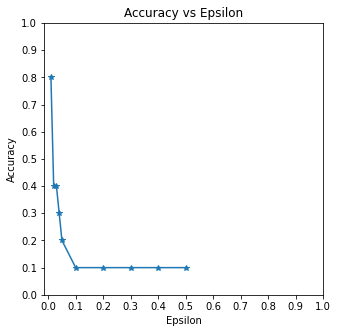

In [187]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [188]:
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())


In [189]:
vals = [c.decode('UTF-8') for c in unpickle('./data/cifar-10-batches-py/batches.meta')[b'label_names']]
count = 0
class_mapping = {}
for v in vals:
    class_mapping[count] = v
    count += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

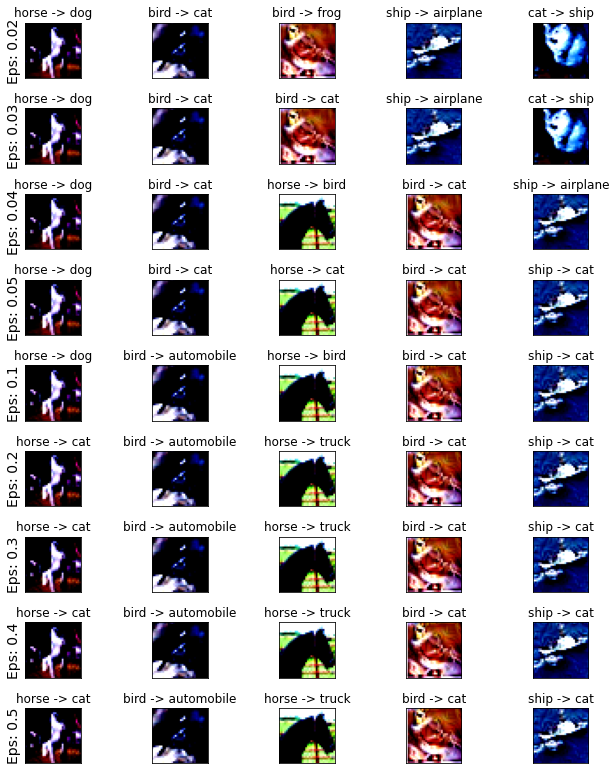

In [212]:
cnt = 0
plt.figure(figsize=(9,12))

for i in range(1, len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[1]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
#         print(orig, adv, class_mapping)
        plt.title("{} -> {}".format(class_mapping[orig], class_mapping[adv]))
#         norm_ex = unnormalize(torch.tensor(ex)).numpy()
        plt.imshow(np.rollaxis(ex, 0, 3))

plt.tight_layout()
plt.savefig('./demo_img.png')
plt.show()

In [210]:
# ex1 = examples[1][0][-1]
# ex2 = examples[-1][0][-1]

# plt.figure(figsize=(3,4))
# plt.imshow(np.rollaxis(ex1, 0, 3))
# plt.ylabel('epsilon = %s'%epsilons[1])

# plt.figure(figsize=(3,4))
# plt.imshow(np.rollaxis(ex2, 0, 3))
# plt.ylabel('epsilon = %s'%epsilons[-1])
# plt.figure(figsize=(3,4))
# plt.imshow(np.rollaxis(ex1 - ex2, 0, 3))


In [424]:
def value_dropout(s, mute_dims = 3):
    # frequency dist
    dist = (s / s.sum(dim = 1, keepdim = True))
    # dropout each channel
    for c in range(3):
        selector = np.random.choice(s.shape[1],
                                    size = mute_dims,
                                    replace = False, 
                                    p = np.flip(dist[c].numpy()))
        s[c][selector] = 0
    
        
def svd_dropout_tranformation(img, dropout_dim):
    u, s, v = torch.svd(torch.tensor(img))
    value_dropout(s, dropout_dim)

    reconst = torch.matmul(torch.matmul(u, torch.diag_embed(s)), v.transpose(-2, -1))
    
    return reconst

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


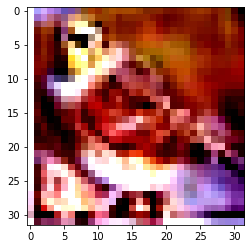

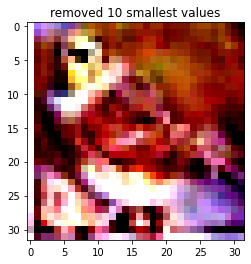

In [454]:
img = examples[0][0][-1]
plt.figure()

plt.imshow(np.rollaxis(img, 0, 3));


removed = 10
plt.figure()
reconst = svd_dropout_tranformation(img, removed)
plt.imshow(np.rollaxis(reconst.numpy(), 0, 3));


plt.title('removed %s smallest values' % removed);